In [353]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import numpy as np

In [354]:
df_tck = pd.read_csv('results/params/t_ckt.csv')
df_Tc = pd.read_csv('results/params/T_c.csv')
df_Tk = pd.read_csv('results/params/T_k.csv')
df_phi = pd.read_csv('../data/processed/city_rent.csv')
df_mj = pd.read_csv('results/params/major_params.csv')
df_share = pd.read_csv('../data/processed/city_occ_employment/city_occ_e_2019.csv')

df_tck = df_tck[df_tck['city_year'].astype(str).str.endswith('2019')]
df_Tc = df_Tc[df_Tc['city_year'].astype(str).str.endswith('2019')]
df_Tk = df_Tk[df_Tk['occ_year'].astype(str).str.endswith('2019')]
df_phi = df_phi[['city', '2019']]

df_phi = df_phi.rename(columns={'2019': 'phi'})
df_phi['phi'] /= 100

df_tck['city'] = df_tck['city_year'].str.split('_').str[0].str.replace(r'[()]', '', regex=True)
df_tck['occ'] = df_tck['occ_year'].str.extract(r'\((.*?)\)')[0]
df_Tc['city'] = df_Tc['city_year'].str.split('_').str[0].str.replace(r'[()]', '', regex=True)
df_Tk['occ'] = df_Tk['occ_year'].str.extract(r'\((.*?)\)')[0]

df_tck = df_tck[['city', 'occ', 't_ckt']]
df_Tc = df_Tc[['city', 'T_c']]
df_Tk = df_Tk[['occ', 'T_k']]

df_tck = df_tck[~df_tck['occ'].str.contains('city_total')]

df_share.set_index('MET2013', inplace=True)
df_share = df_share.div(df_share.sum(axis=1), axis=0)

In [355]:
df_tck_rho = pd.read_csv('results/params/t_ckt_rho.csv')
df_Tc_rho = pd.read_csv('results/params/T_c_rho.csv')
df_Tk_rho = pd.read_csv('results/params/T_k_rho.csv')

df_tck_rho = df_tck_rho[df_tck_rho['city_year'].astype(str).str.endswith('2019')]
df_Tc_rho = df_Tc_rho[df_Tc_rho['city_year'].astype(str).str.endswith('2019')]
df_Tk_rho = df_Tk_rho[df_Tk_rho['occ_year'].astype(str).str.endswith('2019')]

df_tck_rho['city'] = df_tck_rho['city_year'].str.split('_').str[0].str.replace(r'[()]', '', regex=True)
df_tck_rho['occ'] = df_tck_rho['occ_year'].str.extract(r'\((.*?)\)')[0]
df_Tc_rho['city'] = df_Tc_rho['city_year'].str.split('_').str[0].str.replace(r'[()]', '', regex=True)
df_Tk_rho['occ'] = df_Tk_rho['occ_year'].str.extract(r'\((.*?)\)')[0]

df_tck_rho = df_tck_rho[['city', 'occ', 't_ckt']]
df_Tc_rho = df_Tc_rho[['city', 'T_c']]
df_Tk_rho = df_Tk_rho[['occ', 'T_k']]

df_tck_rho = df_tck_rho[~df_tck_rho['occ'].str.contains('city_total')]

In [356]:
def get_z_c(df_Tc, df_phi, theta):
    z_c = df_Tc.copy()
    z_c = z_c.merge(df_phi, on='city')
    z_c['z_c'] = z_c['T_c']
    z_c = z_c.drop(columns=['T_c', 'phi'])
    z_c['z_c'] = z_c['z_c'].apply(lambda x: x ** theta)
    return z_c

def get_lambda_k(df_tck, z_c, rho):
    lambda_k = df_tck.copy()
    lambda_k = lambda_k.merge(z_c, on='city')
    lambda_k['t_ckt'] = lambda_k['t_ckt'] * lambda_k['z_c']
    lambda_k = lambda_k.drop(columns=['z_c'])
    lambda_k['t_ckt'] = lambda_k['t_ckt'].apply(lambda x: x ** (1 / (1 - rho)))
    lambda_k = lambda_k.groupby('occ').sum().reset_index()
    lambda_k = lambda_k.drop(columns=['city'])
    # lambda_k = lambda_k[~lambda_k['occ'].str.contains('city_total')]
    lambda_k = lambda_k.rename(columns={'t_ckt': 'lambda_k'})
    return lambda_k

def get_pi_ck(df_tck, z_c, lambda_k, rho):
    pi_ck = df_tck.copy()
    pi_ck = pi_ck.merge(z_c, on='city')
    pi_ck['t_ckt'] = pi_ck['t_ckt'] * pi_ck['z_c']
    pi_ck = pi_ck.drop(columns=['z_c'])

    pi_ck['t_ckt'] = pi_ck['t_ckt'].apply(lambda x: x ** (1 / (1 - rho)))
    pi_ck = pi_ck.merge(lambda_k, on='occ')
    pi_ck['pi_ck'] = pi_ck['t_ckt'] / pi_ck['lambda_k']
    pi_ck = pi_ck.drop(columns=['t_ckt', 'lambda_k'])
    pi_ck = pi_ck.pivot(index='city', columns='occ', values='pi_ck').reset_index()
    return pi_ck

def get_pi_c(df_tck, df_Tk, z_c, lambda_k, rho):
    pi_c = df_tck.copy()
    pi_c = pi_c.merge(z_c, on='city')
    pi_c['t_ckt'] = pi_c['t_ckt'] * pi_c['z_c']
    pi_c = pi_c.drop(columns=['z_c'])
    pi_c['t_ckt'] = pi_c['t_ckt'].apply(lambda x: x ** (1 / (1 - rho)))

    pi_c = pi_c.merge(lambda_k, on='occ')
    pi_c['t_ckt'] = pi_c['t_ckt'] / pi_c['lambda_k']
    pi_c = pi_c.drop(columns=['lambda_k'])

    omega = df_Tk.copy()
    omega = omega.merge(lambda_k, on='occ')
    omega['lambda_k'] = omega['lambda_k'].apply(lambda x: x ** (1 - rho))
    omega['T_k'] = omega['T_k'] * omega['lambda_k']
    omega = omega.drop(columns=['lambda_k'])
    omega['omega'] = omega['T_k'] / omega['T_k'].sum()
    omega = omega.drop(columns=['T_k'])

    pi_c = pi_c.merge(omega, on='occ', how='left')
    pi_c['pi_c'] = pi_c['t_ckt'] * pi_c['omega']
    pi_c = pi_c.drop(columns=['t_ckt', 'omega'])
    pi_c = pi_c.groupby('city').sum().reset_index()
    pi_c = pi_c.drop(columns=['occ'])
    
    return pi_c

def counterfactual(df, df_rho, pi_c, pi_c_rho, city=None):
    # df = df.rename(columns={'change': 'delta_c_0'})
    # df_rho = df_rho.rename(columns={'change': 'delta_c_1'})
    # pi_c = pi_c.rename(columns={'pi_c': 'pi_c_0'})

    df['pi_1/pi_0'] = df['pi_c'] / pi_c['pi_c']
    df_rho['pi_rho_1/pi_rho_0'] = df_rho['pi_c'] / pi_c_rho['pi_c']

    df = df.merge(df_rho, on='city')
    df = df.merge(pi_c, on='city')
    if city:
        df = df[~df['city'].str.contains(city)]
    df = df[['city', 'pi_1/pi_0', 'pi_rho_1/pi_rho_0']]

    return df

def get_graph(df, x, y, x_name, y_name, annotate, filename=None, line_2=None, line_45=None):
    # Set the style of the plot
    sns.set(style="whitegrid")

    # Enable LaTeX rendering
    plt.rcParams['text.usetex'] = True

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x, y=y, marker='o', color='b', linewidth=2.5)
    if line_2:
        sns.scatterplot(data=df, x=line_2[0], y=line_2[1], marker='s', color='r', linewidth=2.5)
        legend_handles = [
            Line2D([0], [0], color='b', marker='o', label=line_2[2]),
            Line2D([0], [0], color='r', marker='s', label=line_2[3])
        ]
        plt.legend(handles=legend_handles, fontsize=12)

    initial_offset_y = - 0.002
    increment = 0.013

    for i, city in enumerate(annotate):
        text_x = df[df['city'] == city][x].values[0]
        text_y = df[y].min() + initial_offset_y + i * increment  # Stagger the y height
        
        plt.annotate(
            city.split('-')[0], 
            (df[df['city'] == city][x].values[0], df[df['city'] == city][y].values[0]), 
            xytext=(text_x, text_y),
            fontsize=8,
            arrowprops=dict(arrowstyle="->", lw=1, color='red')
        )

    # Customize the plot
    plt.xlabel(x_name, fontsize=14)
    plt.ylabel(y_name, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    if line_45:
        plt.plot([line_45[0], line_45[2]], [line_45[1], line_45[3]], color='lightgreen', linestyle='--', linewidth=2, label='45-degree line')
        

    if filename:
        plt.savefig(filename, bbox_inches='tight')

    # Show the plot
    plt.show()

In [357]:
z_c = get_z_c(df_Tc, df_phi, 3)
lambda_k = get_lambda_k(df_tck, z_c, 0.64)
pi_ck = get_pi_ck(df_tck, z_c, lambda_k, 0.64)
pi_c = get_pi_c(df_tck, df_Tk, z_c, lambda_k, 0.64)

z_c_rho = get_z_c(df_Tc_rho, df_phi, 3)
lambda_k_rho = get_lambda_k(df_tck_rho, z_c_rho, 0)
pi_c_rho = get_pi_c(df_tck_rho, df_Tk_rho, z_c_rho, lambda_k_rho, 0)

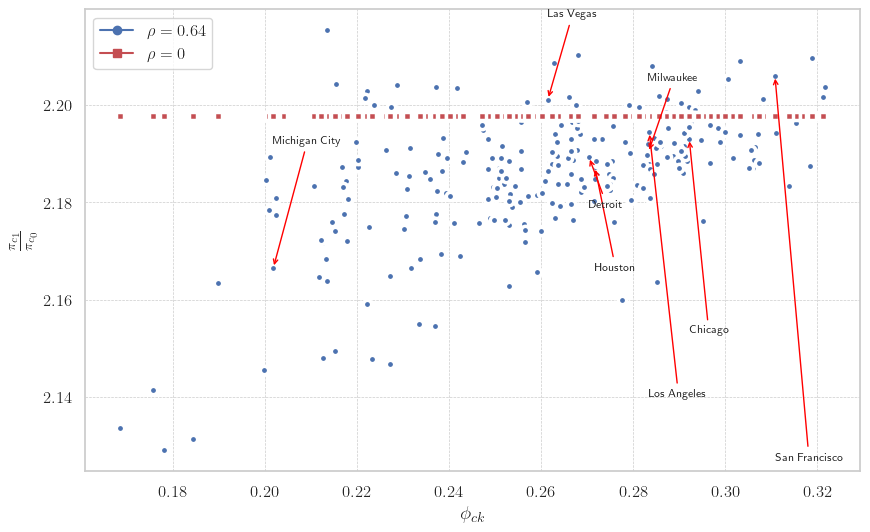

In [358]:
cities = [
    'San Francisco-Oakland-Hayward, CA',
    'Los Angeles-Long Beach-Anaheim, CA',
    'Chicago-Naperville-Elgin, IL-IN-WI',
    'Houston-The Woodlands-Sugar Land, TX',
    'Detroit-Warren-Dearborn, MI',
    'Michigan City-La Porte, IN',
    'Milwaukee-Waukesha-West Allis, WI',
    'Las Vegas-Henderson-Paradise, NV',
]

ny_shock = df_Tc.copy()
ny_shock.loc[ny_shock['city'] == 'New York-Newark-Jersey City, NY-NJ-PA', 'T_c'] *= 0.5
z_c = get_z_c(ny_shock, df_phi, 3)
lambda_k = get_lambda_k(df_tck, z_c, 0.64)
ny_shock = get_pi_c(df_tck, df_Tk, z_c, lambda_k, 0.64)
ny_shock['change'] = ny_shock['pi_c'] - pi_c['pi_c'] 

ny_shock_rho = df_Tc_rho.copy()
ny_shock_rho.loc[ny_shock_rho['city'] == 'New York-Newark-Jersey City, NY-NJ-PA', 'T_c'] *= 0.5
z_c_rho = get_z_c(ny_shock_rho, df_phi, 3)
lambda_k_rho = get_lambda_k(df_tck_rho, z_c_rho, 0)
ny_shock_rho = get_pi_c(df_tck_rho, df_Tk_rho, z_c_rho, lambda_k, 0)
ny_shock_rho['change'] = ny_shock_rho['pi_c'] - pi_c_rho['pi_c']

city_shock = counterfactual(ny_shock, ny_shock_rho, pi_c, pi_c_rho, 'New York-Newark-Jersey City, NY-NJ-PA')
city_shock = city_shock.merge(df_share['occ2_management'], left_on='city', right_index=True)
get_graph(city_shock, 
        'occ2_management', 
        'pi_1/pi_0', 
        r'$\phi_{ck}$', 
        r'$\frac{\pi_{c_1}}{\pi_{c_0}}$',
        cities, 
        'graphs/city_shock.png',
        ['occ2_management',
        'pi_rho_1/pi_rho_0',
        r'$\rho = 0.64$',
        r'$\rho = 0$']
        )
# get_graph(city_shock, 
#         'occ2_management', 
#         'pi_rho_1/pi_rho_0', 
#         r'$\phi_{ck}$', 
#         r'$\frac{\pi_{c_1}}{\pi_{c_0}}$',
#         cities
#         )

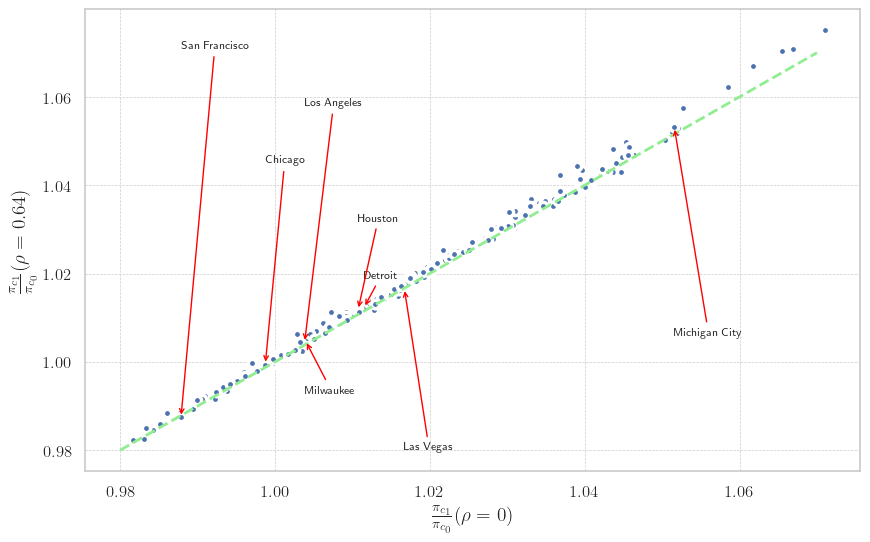

In [359]:
cities.reverse()

df_man_shock = df_Tk.copy()
df_man_shock.loc[df_man_shock['occ'] == 'occ2_management', 'T_k'] *= 0.5
z_c = get_z_c(df_Tc, df_phi, 3)
lambda_k = get_lambda_k(df_tck, z_c, 0.64)
man_shock = get_pi_c(df_tck, df_man_shock, z_c, lambda_k, 0.64)
man_shock['change'] = man_shock['pi_c'] - pi_c['pi_c']

df_man_shock_rho = df_Tk_rho.copy()
df_man_shock_rho.loc[df_man_shock_rho['occ'] == 'occ2_management', 'T_k'] *= 0.5
z_c_rho = get_z_c(df_Tc_rho, df_phi, 3)
lambda_k_rho = get_lambda_k(df_tck_rho, z_c_rho, 0)
man_shock_rho = get_pi_c(df_tck_rho, df_man_shock_rho, z_c_rho, lambda_k_rho, 0)
man_shock_rho['change'] = man_shock_rho['pi_c'] - pi_c_rho['pi_c']

occ_shock = counterfactual(man_shock, man_shock_rho, pi_c, pi_c_rho)
get_graph(
    occ_shock,
    'pi_rho_1/pi_rho_0', 
    'pi_1/pi_0', 
    r'$\frac{\pi_{c_1}}{\pi_{c_0}} (\rho = 0)$', 
    r'$\frac{\pi_{c_1}}{\pi_{c_0}} (\rho = 0.64)$',
    cities, 
    'graphs/occ_shock.png',
    None,
    [0.98, 0.98, 1.07, 1.07]
)